# LAB 6 MOS:  Algoritmos Genéticos para Resolución de Problemas Complejos

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Corridor Crawler (Laberinto Determinístico)

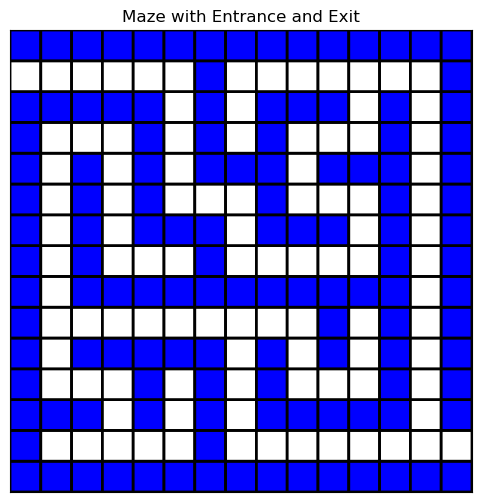

In [129]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Create a function to load the maze from a text file
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'blue'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()


#maze = load_maze('maze_case_base.txt')
maze = load_maze('maze_case_base.txt')
n = maze.shape[0]
#maze[n-2, n-1] = 3  # salida
#maze[9, 10] = 3  # salida
#maze[1, 0] = 3  # entrada
#maze[1, 1] = 2 # medio
#maze[3, 1] = 2 # medio
display_maze(maze)

### Representación Cromosómica

El tamaño del cromosoma será de n², donde n es el tamaño del laberinto. Este tamaño asegura que nunca se necesitarán más de n² pasos para llegar a la salida, ya que el robot siempre encontrará la salida en un número menor de pasos, y las dimensiones del laberinto dictarán el límite máximo de movimientos

Cada gen representará un movimiento. Los posibles movimientos seran 4 direcciones: norte, sur, este, oeste. Cada gen será representado por un número que indica la acción a tomar.

Si en algun punto llega a la salida antes de su ultimo movimiento, se considera que es correcto y no se toma en cuenta lo que quede de cromosoma



### Operadores Geneticos

### Implementación de Operadores Geneticos

In [130]:
# Definir las posibles acciones
from numpy import sqrt


MOVES = ['1', '2', '3', '4']  # Norte, Sur, Este, Oeste

n = maze.shape[0]  # Tamaño del laberinto

def create_individual(n):
    # El cromosoma tiene tamaño n^2 (el tamaño del laberinto)
    return [random.choice(MOVES) for _ in range((n-2)**2)]

# Crear los elementos de DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar aptitud
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()


# Función que envolviera la creación del individuo y le pasara el tamaño 'n'
def create_individual_with_size():
    return create_individual(n)

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual_with_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def penalizacion(n, x, y):
    # Distancia entre el final y el punto x,y
    #dist = (abs(n-1 - x) + abs(n-2 - y)) # Distancia de Manhattan
    dist = sqrt((n-1-x)**2 + (n-2-y)**2)  # Distancia euclidiana
    return dist**2  # Penalización por distancia al objetivo

# Función de aptitud ajustada
def evaluate(individual, maze):
    n = maze.shape[0]  # Tamaño del laberinto
    x, y = 0, 1  # Posición inicial del robot
    steps = 0
    for move in individual:
        steps += 1
        if move == '1':
            y -= 1
        elif move == '2':
            y += 1
        elif move == '3':
            x += 1
        elif move == '4':
            x -= 1

        # Comprobar si el robot choca con una pared (en el laberinto)
        if maze[y][x] == 1:
            return -(n*n) + steps - penalizacion(n,x,y),  # Penalización por colisión
            # Es mejor que el robot choque con una pared luego de haber recorrido una distancia considerable, 
            # por lo que se penaliza menos que si choca luego de varios pasos

        # Comprobar si el robot está fuera de los límites del laberinto
        if x < 0 or y < 0 or x >= n or y >= n:
            return -(n*n) + steps - penalizacion(maze,x,y),  # Penalización por salirse del laberinto

        # Si llegó a la salida (suponiendo que la salida está en la última posición (n-1, n-1))
        if (x, y) == (n-1, n-2):
            # Si llegó a la salida, devuelve positivo
            return n*n - steps,  # Se penaliza por el número de pasos

    # Si no llega a la salida, penaliza la distancia recorrida
    return -steps//2,  # Penaliza por la cantidad de pasos

def mutFlipMove(individual, indpb):
    MOVES = ['1', '2', '3', '4']   # 1=Norte, 2=Sur, 3=Este, 4=Oeste

    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.choice(MOVES)

    return individual,

toolbox.register("evaluate", evaluate, maze = maze)

# Operadores genéticos
toolbox.register("mate", tools.cxOnePoint)  # Cruce de dos puntos
toolbox.register("mutate", mutFlipMove, indpb=0.1)  # Mutación
toolbox.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

pop = toolbox.population(n=200)  # Crear población con 100 individuos

# Parámetros del algoritmo genético
prob_mate = 0.7  # Probabilidad de cruce
prob_mutate = 0.1  # Probabilidad de mutación
generation = 300  # Número de generaciones

# Estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Hall of Fame
hof = tools.HallOfFame(2)

# Ejecución del algoritmo genético
random.seed(40)
pop, log = algorithms.eaSimple(pop, toolbox,
                               cxpb=prob_mate, mutpb=prob_mutate,
                               ngen=generation, stats=stats,
                               halloffame=hof, verbose=True)


c:\Users\57313\anaconda3\envs\pyomo_env\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\57313\anaconda3\envs\pyomo_env\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min 	max 
0  	200   	-566.83	-593	-463
1  	150   	-540.74	-593	-463
2  	147   	-514.31	-593	-463
3  	142   	-496.47	-593	-463
4  	149   	-482.34	-561	-439
5  	157   	-471.23	-593	-427
6  	142   	-462.95	-561	-427
7  	137   	-455.42	-533	-427
8  	148   	-445.84	-541	-427
9  	148   	-435.69	-541	-427
10 	153   	-431.3 	-593	-427
11 	147   	-428.87	-559	-427
12 	141   	-429.3 	-593	-361
13 	137   	-428.94	-593	-361
14 	142   	-429.54	-561	-361
15 	141   	-425.48	-593	-361
16 	151   	-421.12	-561	-361
17 	142   	-403.87	-593	-361
18 	142   	-384.56	-593	-361
19 	153   	-372.91	-589	-361
20 	150   	-366.41	-541	-361
21 	134   	-367.65	-593	-361
22 	142   	-365.49	-593	-361
23 	148   	-366.8 	-561	-361
24 	151   	-366.77	-593	-361
25 	151   	-368.14	-559	-361
26 	144   	-365.11	-511	-361
27 	147   	-367.58	-589	-361
28 	148   	-367.4 	-593	-361
29 	148   	-367.37	-593	-361
30 	152   	-363.14	-489	-361
31 	146   	-367.67	-589	-361
32 	131   	-368.65	-593	-361
33 	141   	-36

### Visualización de Trayectoria


Mejor individuo (cromosoma): ['3', '3', '3', '3', '3', '2', '2', '2', '2', '3', '3', '2', '2', '3', '3', '3', '3', '2', '4', '3', '4', '3', '1', '3', '3', '2', '3', '1', '1', '3', '4', '4', '2', '2', '4', '4', '1', '3', '2', '4', '3', '1', '1', '3', '4', '4', '3', '1', '4', '2', '4', '3', '3', '4', '3', '3', '4', '2', '2', '2', '4', '2', '2', '2', '3', '3', '1', '3', '2', '2', '2', '3', '2', '1', '2', '3', '2', '2', '4', '1', '2', '2', '2', '4', '1', '2', '1', '3', '1', '1', '2', '4', '2', '4', '2', '1', '3', '3', '4', '3', '4', '4', '4', '3', '1', '4', '3', '3', '3', '2', '3', '4', '4', '2', '4', '2', '2', '2', '2', '1', '1', '1', '4', '1', '1', '3', '3', '3', '3', '4', '4', '3', '4', '4', '2', '3', '4', '4', '4', '1', '1', '1', '1', '3', '3', '3', '3', '3', '3', '4', '4', '1', '4', '3', '2', '1', '3', '4', '4', '4', '2', '3', '1', '4', '1', '2', '1', '3', '3']
169
Fitness: -241.0
Chocó con una pared


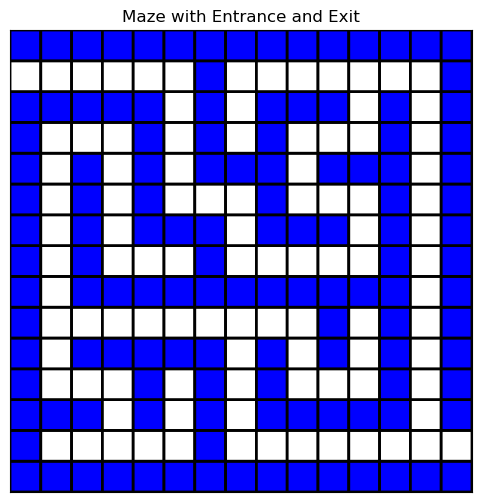

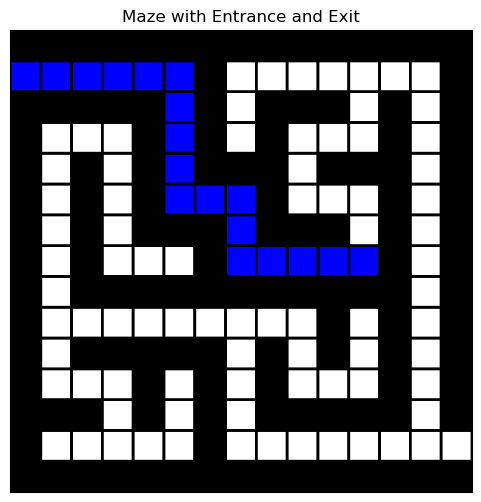

In [131]:
# Mostrar resultados finales
best = hof[0]
print("\nMejor individuo (cromosoma):", best)
print(len(best))
fitness_val = best.fitness.values[0]
print("Fitness:", fitness_val)

#if fitness_val > 0:
    #print("El robot llegó a la salida.")
    # Visualización del camino recorrido por el mejor individuo
path = []
steps = 0
x, y = 0, 1
path.append((x, y))
maze_camino = maze.copy()
maze_camino[1][0] = 3
for move in best:
    steps += 1
    if move == '1': # Moverse hacia arriba
            y -= 1
    elif move == '2': # Moverse hacia abajo
            y += 1
    elif move == '3': # Moverse hacia la derecha
            x += 1
    elif move == '4': # Moverse hacia la izquierda
            x -= 1
    path.append((x, y))
    if maze[y][x] == 1:
        print("Chocó con una pared")
        break
    if not(x < 1 or y < 1 or x >= n or y >= n-1):
        maze_camino[y][x] = 3
    else:
        print("Fuera de los límites del laberinto")
        break
    if (x, y) == (n-1, n-2):
        break  # Salir si llegó a la salida

display_maze(maze)  # Mostrar el laberinto con el camino recorrido
display_maze(maze_camino)  # Mostrar el laberinto con el camino recorrido
#else:
    #print("El robot no llegó a la salida.")


### Analisis de convergencia